In [34]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, log_loss
from PIL import Image


In [35]:
# Function to load images from folder
def load_images_from_folder(folder):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder, filename)).convert('L')  # Convert to grayscale
        if img is not None:
            img = img.resize((100, 100))  # Resize images to a common shape
            images.append(np.array(img))
            if folder.endswith('/Bacterialblight'):
                labels.append('Bacterialblight')
            elif folder.endswith('/Brownspot'):
                labels.append('Brownspot')
            elif folder.endswith('/Leafsmut'):
                labels.append('Leafsmut')
            else:
                labels.append('unknown')  # If folder doesn't match any expected label
    return images, labels

In [36]:
# Paths to your dataset
folder_paths = [
    '/kaggle/input/rice-plant-diseases-dataset/rice leaf diseases dataset/Bacterialblight', 
    '/kaggle/input/rice-plant-diseases-dataset/rice leaf diseases dataset/Brownspot', 
    '/kaggle/input/rice-plant-diseases-dataset/rice leaf diseases dataset/Leafsmut'
]
images = []
all_labels = []

for folder_path in folder_paths:
    folder_images, folder_labels = load_images_from_folder(folder_path)
    images.extend(folder_images)
    all_labels.extend(folder_labels)

# Convert to numpy arrays
X = np.array(images)
y = np.array(all_labels)

# Store original images for visualization
X_original = X.copy()

# Flatten the images for the classifier
X = X.reshape(X.shape[0], -1)

In [37]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Cross-validation with k-NN before LDA
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
knn = KNeighborsClassifier(n_neighbors=7, metric='euclidean')

train_accuracies_no_lda = []
test_accuracies_no_lda = []
for train_index, test_index in skf.split(X_train, y_train_encoded):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train_encoded[train_index], y_train_encoded[test_index]

    # Train the model
    knn.fit(X_train_fold, y_train_fold)
    
    # Evaluate the model
    train_accuracies_no_lda.append(accuracy_score(y_train_fold, knn.predict(X_train_fold)))
    test_accuracies_no_lda.append(accuracy_score(y_test_fold, knn.predict(X_test_fold)))

print("Before LDA Feature Selection and cross validation")
print(f"Average Training Accuracy: {np.mean(train_accuracies_no_lda) * 100:.2f}%")
print(f"Average Testing Accuracy: {np.mean(test_accuracies_no_lda) * 100:.2f}%")


Before LDA Feature Selection and cross validation
Average Training Accuracy: 66.89%
Average Testing Accuracy: 55.91%


In [38]:
# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train KNN classifier on scaled data
knn.fit(X_train_scaled, y_train_encoded)

# Make predictions before LDA
y_pred_no_lda = knn.predict(X_test_scaled)

# Evaluate the model before LDA
train_accuracy_no_lda = accuracy_score(y_train_encoded, knn.predict(X_train_scaled))
test_accuracy_no_lda = accuracy_score(y_test_encoded, y_pred_no_lda)
train_loss_no_lda = log_loss(y_train_encoded, knn.predict_proba(X_train_scaled))
test_loss_no_lda = log_loss(y_test_encoded, knn.predict_proba(X_test_scaled))

print("\nBefore LDA:")
print(f"Validation Accuracy: {test_accuracy_no_lda * 100:.2f}%")
print(f"Validation Loss: {test_loss_no_lda:.4f}")


Before LDA:
Validation Accuracy: 55.82%
Validation Loss: 2.1015


In [39]:
# Apply LDA for dimensionality reduction with 2 components
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_scaled, y_train_encoded)
X_test_lda = lda.transform(X_test_scaled)

# Train KNN classifier after LDA
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(X_train_lda, y_train_encoded)

# Make predictions after LDA
y_pred_lda = knn.predict(X_test_lda)

# Evaluate the model after LDA
train_accuracy_lda = accuracy_score(y_train_encoded, knn.predict(X_train_lda))
test_accuracy_lda = accuracy_score(y_test_encoded, y_pred_lda)
train_loss_lda = log_loss(y_train_encoded, knn.predict_proba(X_train_lda))
test_loss_lda = log_loss(y_test_encoded, knn.predict_proba(X_test_lda))

print("\nAfter LDA :")
print(f"Validation Accuracy: {test_accuracy_lda * 100:.2f}%")
print(f"Validation Loss: {test_loss_lda:.4f}")


After LDA :
Validation Accuracy: 94.24%
Validation Loss: 1.9295


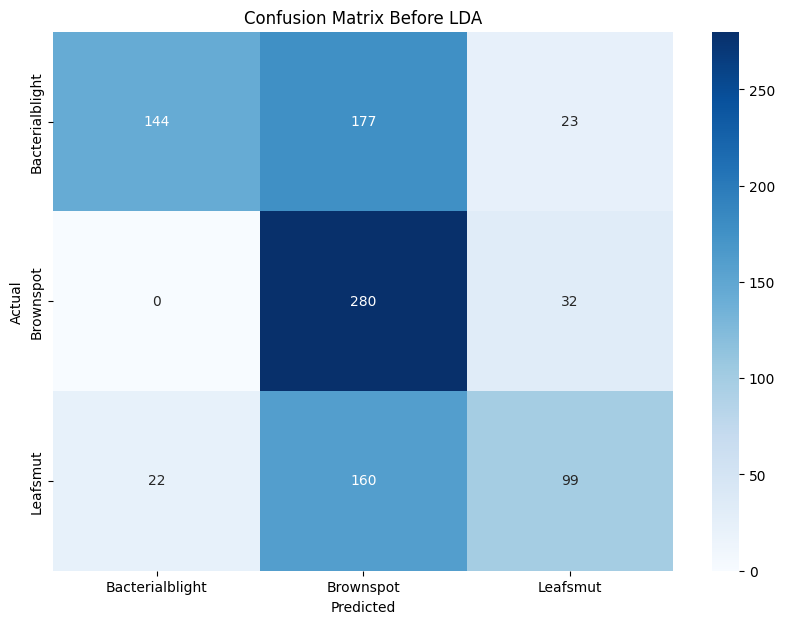

In [40]:
# Confusion matrix before LDA
cm_no_lda = confusion_matrix(y_test_encoded, y_pred_no_lda)

# Confusion matrix after LDA
cm_lda = confusion_matrix(y_test_encoded, y_pred_lda)

# Visualization

# Confusion Matrix Heatmap (Before LDA)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_no_lda, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix Before LDA')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


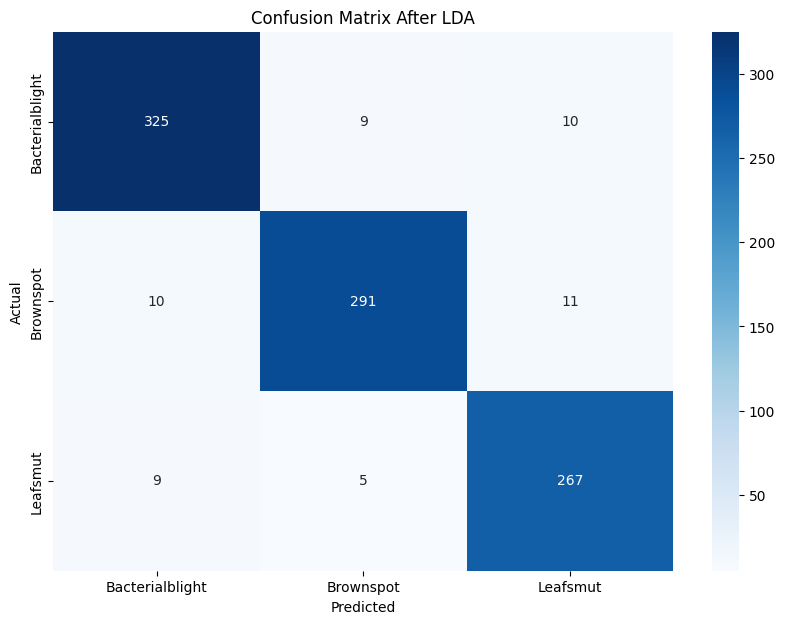

In [41]:
# Confusion Matrix Heatmap (After LDA)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_lda, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix After LDA')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

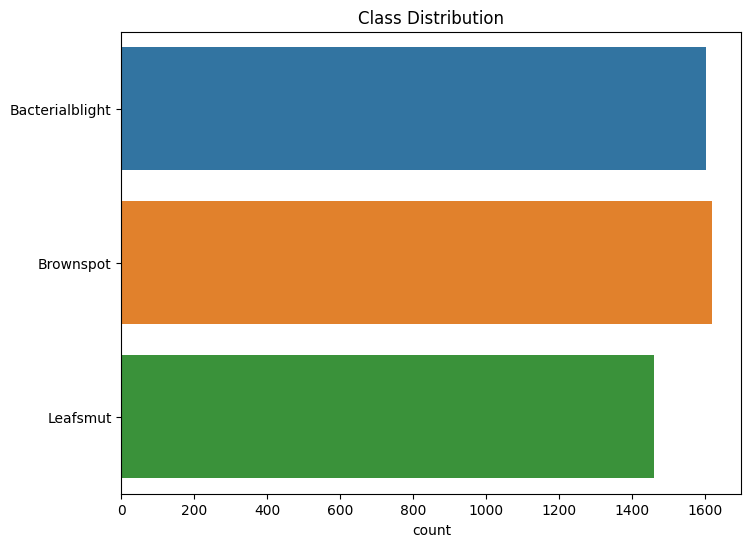

In [42]:
# Bar chart for class distribution
plt.figure(figsize=(8, 6))
sns.countplot(y=y, order=label_encoder.classes_)
plt.title('Class Distribution')
plt.show()

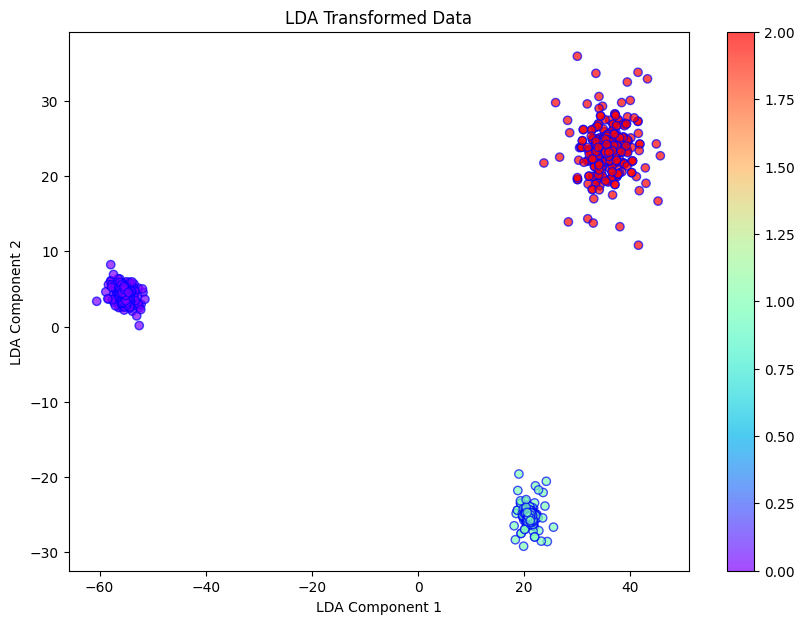

In [43]:
# Plot the LDA transformed data
plt.figure(figsize=(10, 7))
plt.scatter(X_train_lda[:, 0], X_train_lda[:, 1], c=y_train_encoded, cmap='rainbow', alpha=0.7, edgecolors='b')
plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
plt.title('LDA Transformed Data')
plt.colorbar()
plt.show()

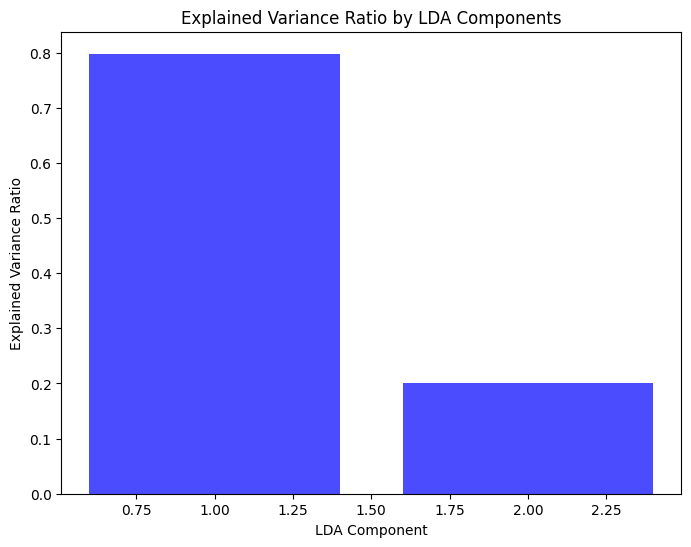

In [44]:
# Explained Variance Ratio for LDA components
lda_explained_variance = lda.explained_variance_ratio_

plt.figure(figsize=(8, 6))
plt.bar(range(1, len(lda_explained_variance) + 1), lda_explained_variance, alpha=0.7, color='blue')
plt.xlabel('LDA Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by LDA Components')
plt.show()



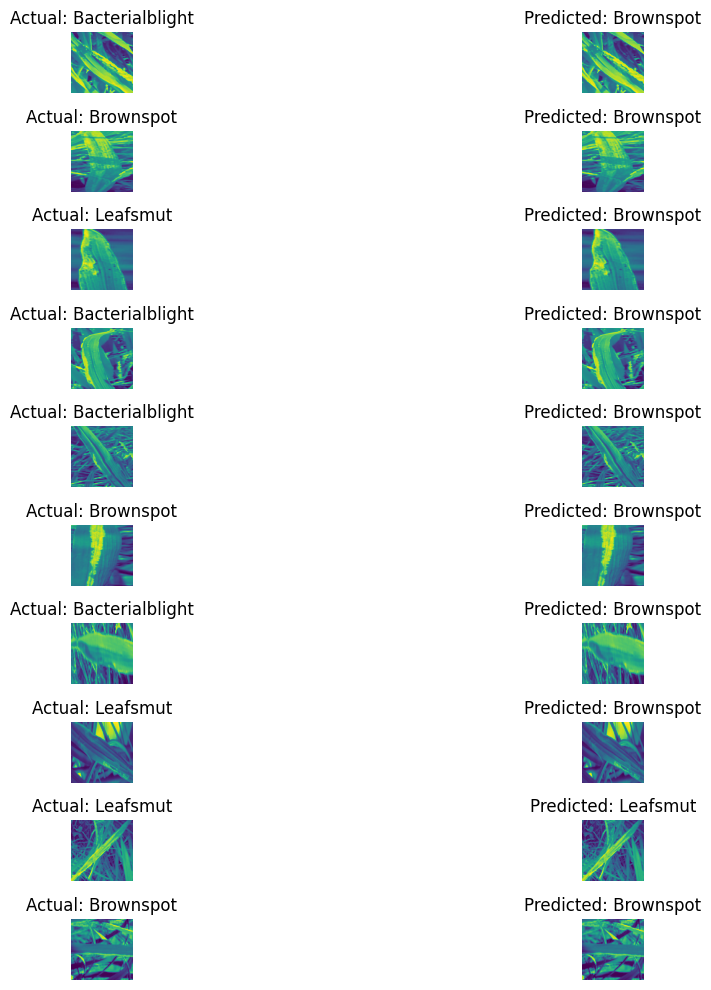

In [45]:
# Visualization of Actual vs Predicted Images
num_samples = 10  # Number of samples to display
indices = np.random.choice(range(len(X_test)), num_samples, replace=False)

plt.figure(figsize=(15, 10))
for i, index in enumerate(indices):
    plt.subplot(num_samples, 2, 2 * i + 1)
    img_actual = X_original[index].reshape(100, 100)
    plt.imshow(img_actual)
    actual_label = label_encoder.inverse_transform([y_test_encoded[index]])[0]
    plt.title(f'Actual: {actual_label}')
    plt.axis('off')

    plt.subplot(num_samples, 2, 2 * i + 2)
    img_predicted = X_original[index].reshape(100, 100)
    plt.imshow(img_predicted)
    predicted_label = label_encoder.inverse_transform([y_pred_no_lda[index]])[0]
    plt.title(f'Predicted: {predicted_label}')
    plt.axis('off')

plt.tight_layout()
plt.show()


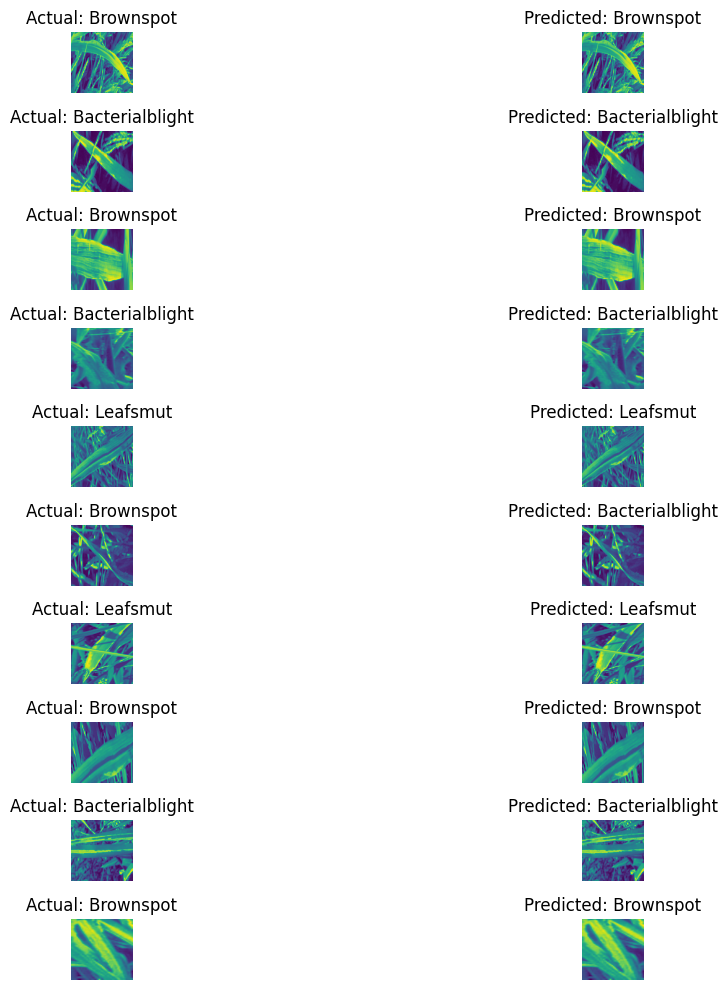

In [48]:
# Visualization of Actual vs Predicted Images
num_samples = 10  # Number of samples to display
indices = np.random.choice(range(len(X_test)), num_samples, replace=False)

plt.figure(figsize=(15, 10))
for i, index in enumerate(indices):
    plt.subplot(num_samples, 2, 2 * i + 1)
    img_actual = X_original[index].reshape(100, 100)
    plt.imshow(img_actual)
    actual_label = label_encoder.inverse_transform([y_test_encoded[index]])[0]
    plt.title(f'Actual: {actual_label}')
    plt.axis('off')

    plt.subplot(num_samples, 2, 2 * i + 2)
    img_predicted = X_original[index].reshape(100, 100)
    plt.imshow(img_predicted)
    predicted_label = label_encoder.inverse_transform([y_pred_lda[index]])[0]
    plt.title(f'Predicted: {predicted_label}')
    plt.axis('off')

plt.tight_layout()
plt.show()
